In [23]:
import os
import re
import numpy as np
from TwitterAPI import TwitterAPI
import ConfigParser
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
def labl(filename):
    """
We have a file with labels corresponding to each class
Params:
filename:The name of the file from which the labels have to be read from
Returns
label: A dictionary with the key as the class and the item as the name of the class
"""
    label={}
    with open(filename) as f:
        for l in f:
            label[l.split(':')[0]]=l.split(':')[1].strip()
    return label

In [25]:
def count_classifier(path):
    """
This function is used to read the tweets from the files.We have 7 files,one file for each class.
Params:
Path: path has the location of the files with the tweets
Returns:
num_list: is a list with number of tweets in each file 
file_list: is a list with the name of the files
""" 
   
    file_list=[]
    k=os.listdir(path)
    num_list=[]
    for t in k:
        if t.endswith('.txt'):
            file_list.append(t)
    for k in file_list:
        with open(path+os.sep+k) as f:
            p=f.read().count('<endofTweet>')
            
            num_list.append(p)
        
    return num_list,file_list

path='data'
lab=labl('label.txt')
num_list,file_list=count_classifier(path)
for m in range(len(num_list)):
    
    print lab[file_list[m].split('.txt')[0]]+' : '+'%d'%num_list[m]
print 'We will be training our classifier using %d tweets from each class' %min(num_list)

Sad : 399
Happy : 399
We will be training our classifier using 399 tweets from each class


In [26]:
print num_list
print file_list

[399, 399]
['-1.txt', '1.txt']


In [27]:
def get_true_labels(file_list,num_list):
    """
    Constructs the Training set true values for the classifier
    Params:
    file_list:list of files to be considered
    num_list:the number of tweets in each class
    Returns:
    An array of training set true values of the tweets
    """
    a=np.empty(len(file_list)*min(num_list),dtype=int)
    n=0
    for k in file_list:
        for p in range(min(num_list)):
            a[n]=k.split('.txt')[0]
            n=n+1
           
    return a



In [28]:
def tokenize(txt):
    """
    This tokenizing function removes all the mentions,urls and punctuations
    Params:
    txt: A string to be tokenized
    Returns
    A lower case txt with all mentions,urls and punctuations removed
    """
    l=''
    for m in (txt.split('<endofTweet>')[0]).split():
        if (m[0:5]!='https') and m[0]!='@':
            l=l+m+' '
    return re.sub('\W+', ' ',l.lower())
print (tokenize("Go get this. You won't be sorry. Go get this. You won't be sorry. Go get this. YOU WON'T BE SOORY.  https://t.co/iP4tM0MfKx<endofTweet>"))

go get this you won t be sorry go get this you won t be sorry go get this you won t be soory 


In [29]:
def tweet_list(file_list,num_list,path):
    """
    Constructs the Training set X values for the classifier
    Params:
    file_list:list of files to be considered
    num_list:the number of tweets in each class
    path: the location of the files
    Returns:
    A list of tweets to be considered for the classifier
    """
    lis=[]
    for k in file_list:
        with open(path+os.sep+k) as f:
            for m in range(min(num_list)):
                lis.append(tokenize(f.readline()))
    return lis



In [30]:
def classify(X_train,Y_train,min_df=1,
                 max_df=1., binary=True,tfidf=True,clas='OVR'):
    
    """Constructs a classifier according to the specifications given
    Params:
    X_train:The training set X values
    Y_train:The training set Y values
    tfidf:If this is true, TfidfTransformer will be used
    clas=if this parameter is OVR then OneVsRestClassifier will be used and if the value is
         LOG then LogisticRegression will be used
    Returns:
    classifier:The constructed classifier will be returned
    """
    if(tfidf==True and clas=='OVR'):
        
        classifier = Pipeline([
            ('vectorizer', CountVectorizer(min_df=min_df,max_df=max_df, binary=binary)),
            ('tfidf', TfidfTransformer()),
            ('clf', OneVsRestClassifier(LinearSVC()))])
    if (tfidf==False and clas=='OVR'):
        
        classifier = Pipeline([
            ('vectorizer', CountVectorizer(min_df=min_df,max_df=max_df, binary=binary)),
            ('clf', OneVsRestClassifier(LinearSVC()))])
    if(tfidf==True and clas=='LOG'):
        
        classifier = Pipeline([
            ('vectorizer', CountVectorizer(min_df=min_df,max_df=max_df, binary=binary)),
            ('tfidf', TfidfTransformer()),
            ('clf', LogisticRegression())])
    if(tfidf==False and clas=='LOG'):
        
        classifier = Pipeline([
            ('vectorizer', CountVectorizer(min_df=min_df,max_df=max_df, binary=binary)),
            ('clf', LogisticRegression())])
    classifier.fit(X_train, Y_train)
    return classifier



In [31]:
def do_cross_validation(X, y,  verbose=False,fld=5,min_df=1,
                 max_df=1., binary=True,tfidf=True,clas='OVR'):
    
    """
    Perform n-fold cross validation, calling get_clf() to train n
    different classifiers. Use sklearn's KFold class: http://goo.gl/wmyFhi
    Be sure not to shuffle the data, otherwise your output will differ.
    Params:
        X.........a csr_matrix of feature vectors
        y.........the true labels of each document
        n_folds...the number of folds of cross-validation to do
        verbose...If true, report the testing accuracy for each fold.
    Return:
        the average testing accuracy across all folds.
    """
    ###TODO
    ###
    cv = KFold(len(Y_train), fld)
    accuracies = []
    for train_idx, test_idx in cv:
        XT=[]
        X=[]
        for p in  train_idx:
            X.append(X_train[p])
        for p in  test_idx:
            XT.append(X_train[p])
        clf= classify(X,Y_train[train_idx],min_df=min_df,
                 max_df=max_df, binary=binary,tfidf=tfidf,clas=clas)
        predicted = clf.predict(XT)
        acc = accuracy_score(Y_train[test_idx], predicted)
        accuracies.append(acc)
    if verbose==True:
        k=0
        for m in accuracies:
            
            print 'fold %d accuracy=%.4f'%(k,m)
            k=k+1
    avg = np.mean(accuracies)
    return avg
    



In [32]:
"""Lets try different combinations of OneVsRestClassifier and OneVsRestClassifier with TfidfTransformer enabled and disabled """
Y_train=get_true_labels(file_list,num_list)
X_train=tweet_list(file_list,num_list,path)
for clas in ('OVR','LOG'):
    for tfidf in (True,False):
        if clas=='OVR':
            print 'OneVsRestClassifier',
        
        else:
            print 'LogisticRegression' ,
        if tfidf==True:
            print 'TfidfTransformer enabled'
        else:
            print 'TfidfTransformer disabled'
        
        classifier=classify(X_train,Y_train,clas=clas,tfidf=tfidf)
        print do_cross_validation(X_train,Y_train,tfidf=tfidf,clas=clas)

OneVsRestClassifier TfidfTransformer enabled
0.657830188679
OneVsRestClassifier TfidfTransformer disabled
0.626438679245
LogisticRegression TfidfTransformer enabled
0.451037735849
LogisticRegression TfidfTransformer disabled
0.578797169811


OneVsRestClassifier with TfidfTransformer enabled has the highest accuracy so we will be using this for our classifier

In [33]:
"""Lets try different combinations of min_df,max_df,binary in our classifier"""
acc=[]
mindf=[]
maxdf=[]
binry=[]
for binary in [True,False]:
    for min_df in range(1,11):
        for max_df in [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]:
            classifier=classify(X_train,Y_train,min_df=min_df,max_df=max_df, binary=binary)
            acc.append(do_cross_validation(X_train,Y_train, verbose=False,fld=5,min_df=min_df,max_df=max_df, binary=binary))
            mindf.append(min_df)
            maxdf.append(max_df)
            binry.append(binary)

val=0
ind=0
for m in range(len(acc)):
    if val<acc[m]:
        val=acc[m]
        ind=m
print val
print mindf[ind],
print maxdf[ind],
print binry[ind]

0.661580188679
1 0.2 True


The classifier has the highest accuracy when min_df=1,max_df=0.2 and binary=True 

In [34]:
def holdback_10_percent(classify,X_train,Y_train):
    t= (min(num_list)*len(file_list))*10/100

    X=[]
    Y=[]
    XT=[]
    YT=[]
    for p in range(len(X_train)):
        if(p%t==0):
            XT.append(X_train[p])
            YT.append(Y_train[p])
        else:
            X.append(X_train[p])
            Y.append(Y_train[p])
    clf=classify(X,Y,max_df=0.2)
    predicted = clf.predict(XT)
    acc = accuracy_score(YT, predicted)
    return acc
print holdback_10_percent(classify,X_train,Y_train)

1.0


In [35]:
def get_twitter(config_file):
    """ Read the config_file and construct an instance of TwitterAPI.
    Args:
      config_file ... A config file in ConfigParser format with Twitter credentials
    Returns:
      An instance of TwitterAPI.
    """
    config = ConfigParser.ConfigParser()
    config.read(config_file)       
    twitter = TwitterAPI(
                   config.get('twitter', 'consumer_key'),
                   config.get('twitter', 'consumer_secret'),
                   config.get('twitter', 'access_token'),
                   config.get('twitter', 'access_token_secret'))
    print("Established Twitter Connection")
   
    return twitter

def data_clctr(n,twitter,lang,show_num=True):
    """Collects the tweets from usa,apply the tokenizer function and return the tweets in a list
    Params:
    nn:umber of tweets to be collected
    twitter:an instance of twitterAPI
    lang:The language of the tweets to be collected
    show_num:If set true sows the progress of the tweeets being collected
    Returns
    A list of tweets collected
    """
    r=twitter.request('statuses/filter',{'locations':'-124.637,24.548,-66.993,48.9974'})
    m=0
    tweets=[]
    print "Collecting tweets..."
    while (m<n):
        item=r.get_iterator().next()
       
        if 'text' in item and 'lang' in item:
            if item['lang']==lang:
                m=m+1
                tweets.append(tokenize(item['text']))
                if show_num==True:
                    print m
    print ("Tweets collected")
    return tweets

num=1000
number_of_tweets=num
lan='en'
lis=data_clctr(num,get_twitter('twitter.cfg'),lan,show_num=False)

Established Twitter Connection
Tweets collected


Sad : 49
Happy : 51

The predominant mood is Happy


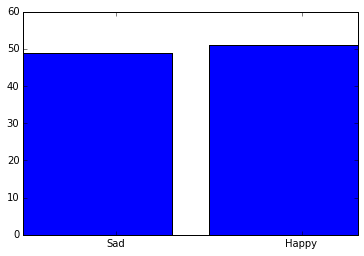

In [36]:


def predict(classifier,lis):
    """Predicts the mood of the tweets in the list
    Params:
    classifier:The classifier to be used
    lis:The list of tweets
    Returns:
    Predictions:The list of predictions made by the classifier
    """
    predictions=classifier.predict(lis)
    k=0
    for t in predictions:
        k=k+t
    return predictions



def data_analysis(predictions,file_list,number_of_tweets):
    """Does analysis on the collected tweets and returns a dictionary with calculated values
    Params:
    Predictions:The list of predictions made
    File_list:list of files used in the classifier
    number_of_tweets:The number of tweets collected
    Returns
    dic1:A dictionary with number of tweets,percentage of tweets per each mood"""
    lis=[]
    dic={}
    dic1={}
    for m in predictions:
        lis.append(m)
    for m in file_list:
    
        dic[(int(m.split('.txt')[0]))]=lis.count(int(m.split('.txt')[0]))
    for p in dic.keys():
        dic1[label[str(p)]]={'number':dic[p],
                             'percentage':dic[p]*100/number_of_tweets,
                             'weighted_point':dic[p]*p,
                             'weight':p}
    
    return dic1

def predominant_mood(data_dic,percent_show=True):
    """Calculates the predominant mood 
    Params:
    data_dic: The dictionary with calculated values about the moods
    percent_show:If set true will show the percentage of each mood
    Returns:
    n:The predominant mood"""
    
    l=0
    n=''
    for m in data_dic.keys():
        if percent_show==True:
            print m+' : %d'%data_dic[m]['percentage']
        if l<data_dic[m]['percentage']:
            l=data_dic[m]['percentage']
            n=m
    return n

classifier=classify(X_train,Y_train,max_df=0.2)
label=labl('label.txt')
predictions=predict(classifier,lis)
data_dic=data_analysis(predictions,file_list,number_of_tweets)
print '\nThe predominant mood is '+predominant_mood(data_dic,percent_show=True)
plt.figure()
plt.bar([0, 1],[data_dic['Sad']['percentage'],data_dic['Happy']['percentage']] )
plt.xticks([.5, 1.5], ['Sad','Happy'])
plt.show()

In [37]:
def tweet_analysis(classifier,path,m,t):
    """Returns the percentage of happy and sad tweets in a file
    Param:
    classifier:The classifier to be used
    path:The path
    m:the day
    t:name of the file
    Returns:
    a tuple of sad and happy tweet percentage in the given file"""
    
    lis=[]
    with open(path+os.sep+m+os.sep+t) as f:
                for m in range(10000):
                    lis.append(tokenize(f.readline()))
    predictions=predict(classifier,lis)
    data_dic=data_analysis(predictions,file_list,10000.000)
    return [data_dic['Sad']['percentage'],data_dic['Happy']['percentage']]


def week_mood(path):
    """determines the percentage of happy and sad moods made in each day of the week
    Param:
    path:the path
    Returns:
    A tuple of list of days in the week,percentage od sad tweets in that day and percentage of happy tweets made in that day"""
    week=['monday','tuesday','wednesday','thursday','friday','saturday','sunday']
    
    sd=[]
    hppy=[]
    for m in week:
        l=[]
        k=os.listdir(path+os.sep+m)
        sad=0
        happy=0
        n=0
        for t in k:
            if t.endswith('.txt'):
            #print path,
            #print m,
            
                s,h=tweet_analysis(classifier,path,m,t)
                sad=sad+s
                happy=happy+h
        sd.append(round((sad/10),2))
        hppy.append(round((happy/10),2))
    return week,sd,hppy


week,sd,hppy=week_mood('data_week')

print week
print sd
print hppy


['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
[52.93, 46.85, 46.02, 46.04, 47.68, 47.36, 49.73]
[47.07, 53.15, 53.98, 53.96, 52.32, 52.64, 50.27]


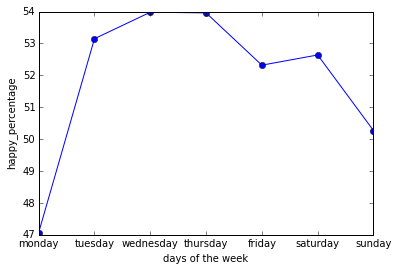

In [38]:
def plt_graph(week,hppy):
    """Plot a graph showing the transition of percentage of happiness as the week progresses
    Params:
    week:list of days in a week
    hppy:list of percentage of happy tweets made each day"""
    
    plt.plot(range(len(week)),hppy,marker='o')
    plt.xticks(range(len(week)),week)
    plt.ylabel('happy_percentage')
    plt.xlabel('days of the week')
    plt.show()
plt_graph(week,hppy)